# Prevendo qualidade de vinho com regressão

---

- [Enunciado](#enunciado)
- [Setup](#setup)
  - [Importando pacotes e dados](#importando-pacotes-e-dados)
  - [Declarações de funções](#declarações-de-funções)
- [EDA](#eda)
  - [Overview dos dados](#overview-dos-dados)
  - [Visualizando dados](#visualizando-dados)
  - [Lidando com outliers](#lidando-com-outliers)
  - [Correlação](#correlação)
  - [Feature Engineering](#feature-engineering)
  - [Separando dados](#separando-dados)
- [Modelagem](#modelagem)
  - [Modelagem simples](#modelagem-simples)
  - [Modelagem com `RandomSearchCV`](#modelagem-com-randomsearchcv)
- [Avaliando performance](#avaliando-performance)
  - [Coeficiente de determinação $R^2$](#coeficiente-de-determinação)
  - [Raiz do erro quadrático médio](#raiz-do-erro-quadrático-médio)
  - [Prevendo valores](#prevendo-valores)
  - [Resultados](#resultados)
  - [Feature Importance](#feature-importance)
- [Salvando modelos](#salvando-modelos)
- [Conclusão](#conclusão)

---

## Enunciado

O vinho verde é um produto único da região de Minho, do Noroeste de Portugal. Médio em álcool, este vinho é particularmente apreciado devido ao seu frescor, especialmente no verão. Com base nisso, foram coletadas as seguintes informações sobre o vinho:

1. Acidez fixa (fixed acidity).
2. Acidez critica (critical acidity).
3. Acidez volátil (volatile acidity).
4. Açúcar residual (residual sugar).
5. Concentração de cloretos (chlorides).
6. Concentração de dióxido sulfúrico livre (free sulphur dioxide).
7. Concentração total dióxido sulfúrico (free sulphur dioxide).
8. Densidade (density).
9. pH (pH).
10. Concentração de sulfatos (sulphates).
11. Concentração alcoólica (alcohol).

Output (baseado na avaliação média de especialistas):

12. Qualidade (quality) (score 0-10).

Há dois datasets, relacionados às variantes vermelha e branca do "vinho verde", de Portugal. Escolha um dos datasets contendo informações de uma das variantes (vermelha ou branca) e crie um modelo de regressão para prever a qualidade do vinho. A entrega é individual e deverá ser colocada no github pessoal


## Setup


### Importando pacotes e dados


In [ ]:
# Importando pacotes

# Type hinting
from typing import Tuple, List, Dict
from sklearn.base import BaseEstimator

# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Utilidades
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Métricas
from sklearn.metrics import root_mean_squared_error

# Modelo regressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Importando dados
red_wine_df = pd.read_csv('../datasets/winequality/winequality-red.csv', sep=';')
white_wine_df = pd.read_csv('../datasets/winequality/winequality-white.csv', sep=';')

In [3]:
# Head do dataset de vinho branco
red_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Head do dataset de vinho branco
white_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Declarações de funções


In [5]:
# Função para imprimir boxplots dos dados
def dataframe_boxplots(
    df: pd.DataFrame, color_dict: Dict[str, Tuple[float, float, float]]
) -> None:
    _, ax = plt.subplots(nrows=4, ncols=3, figsize=(30, 18))

    axes = ax.flatten()
    for i, column in enumerate(df):
        sns.boxplot(df[column], orient='h', color=color_dict[column], ax=axes[i])
        axes[i].set_title(f'Boxplot {column}')
    plt.suptitle('Features boxplots')
    plt.tight_layout()
    plt.show()

In [6]:
# Função para imprimir histograma dos dados
def dataframe_histograms(
    df: pd.DataFrame, color_dict: Dict[str, Tuple[float, float, float]]
) -> None:
    _, ax = plt.subplots(nrows=4, ncols=3, figsize=(30, 18))

    axes = ax.flatten()
    for i, column in enumerate(df):
        sns.histplot(df[column], color=color_dict[column], ax=axes[i])
        axes[i].set_title(f'Histogram {column}')
    plt.suptitle('Features distributions')
    plt.tight_layout()
    plt.show()

In [7]:
# Função para imprimir visualização de correlação
def plot_correlation(
    corr_df: pd.Series, color_dict: Dict[str, Tuple[float, float, float]]
) -> None:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=corr_df.values,
        hue=corr_df.index,
        palette='Paired',
    )
    plt.title('Correlation of columns and diabetes diagnose (Outcome)', fontsize=12)
    plt.xlabel('Pearson Correlation')
    plt.ylabel('Columns')
    plt.tight_layout()
    plt.show()

In [8]:
# Função para calcular os limites inferiores e superiores
def upper_lower_limit(
    data: pd.DataFrame, col_name: str, quantile: np.float64 = None
) -> Tuple[np.float64, np.float64]:
    # Retornando determinado quantil
    if quantile:
        return data[col_name].quantile(quantile), data[col_name].quantile(1 - quantile)

    # Calculando quantis
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)

    # Calculando limites
    upper_whisker = min(q3 + 1.5 * (q3 - q1), data[col_name].max())
    lower_whisker = max(q1 - 1.5 * (q3 - q1), data[col_name].min())

    return upper_whisker, lower_whisker

In [9]:
# Função para calcular quantidade de outliers
def print_num_outliers(
    data: pd.DataFrame, col_name: str, whiskers: Tuple[np.float64, np.float64]
) -> None:
    upper_outliers = (data[col_name] > whiskers[0]).sum()
    lower_outliers = (data[col_name] < whiskers[1]).sum()

    name_text = f'{col_name}\'s outliers:'
    outlier_text = f'{upper_outliers} (upper) | {lower_outliers} (lower) | {upper_outliers + lower_outliers} (total) |'

    print('-' * 80)
    print(name_text, ' ' * (78 - len(name_text + outlier_text)), outlier_text)

In [10]:
# Função para imprimir valores dos limites
def print_whiskers(col_name: str, whiskers: Tuple[np.float64, np.float64]) -> None:
    name_text = f'{col_name}\'s whiskers:'
    outlier_text = f'{whiskers[0]:.2f} (upper) | {whiskers[1]:.2f} (lower) |'

    print('-' * 80)
    print(name_text, ' ' * (78 - len(name_text + outlier_text)), outlier_text)

In [11]:
# Função para remoção de outliers
def remove_outliers(
    df: pd.DataFrame,
    columns: List[str],
    whiskers_dict: Dict[str, Tuple[np.float64, np.float64]],
    remove_upper: bool = True,
    remove_lower: bool = True,
) -> pd.DataFrame:
    mask = pd.Series(True, index=df.index)
    for col in columns:
        upper, lower = whiskers_dict[col]
        col_mask = pd.Series(True, index=df.index)

        if remove_upper:
            col_mask &= df[col] <= upper
        if remove_lower:
            col_mask &= df[col] >= lower

        mask &= col_mask

    return df[mask].copy(deep=True)

In [12]:
# Função para gerar pipeline de XGBRegressor
def estimator_pipeline(estimator: BaseEstimator) -> Pipeline:
    return Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('model', estimator(random_state=42)),
        ]
    )

## EDA


### Overview dos dados

O dataset contendo informações sobre vinhos brancos possui quase 3 vezes a quantidade de dados. Com base nisso ele será o escolhido.

Além disso vale notar que todos os valores são do tipo `float64` e que não exitem valores faltantes.


In [13]:
# Obtendo informações sobre os datasets
red_wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [14]:
# Obtendo informações sobre os datasets
white_wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [15]:
# Criando cópia do dataset original
wine_df = white_wine_df.copy(deep=True)

In [16]:
# Descrevendo dados de vinho branco
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Visualizando dados

Os boxplots de `volatile acidity` e `chlorides` demonstram uma grande quantidade de outliers. Juntamente com os boxplots, os histogramas das features mostram grande assimetria dessas mesmas medidas, além de outras, como `residual sugar`, `free sulfur dioxide`, e `density`.


In [17]:
# Criando dict de pallete
sns.set_theme(style='darkgrid')
sns.set_context('notebook', font_scale=1.2)
colors = sns.color_palette('Paired', len(white_wine_df.columns))
color_dict = {
    white_wine_df.columns[i]: colors[i] for i in range(len(white_wine_df.columns))
}

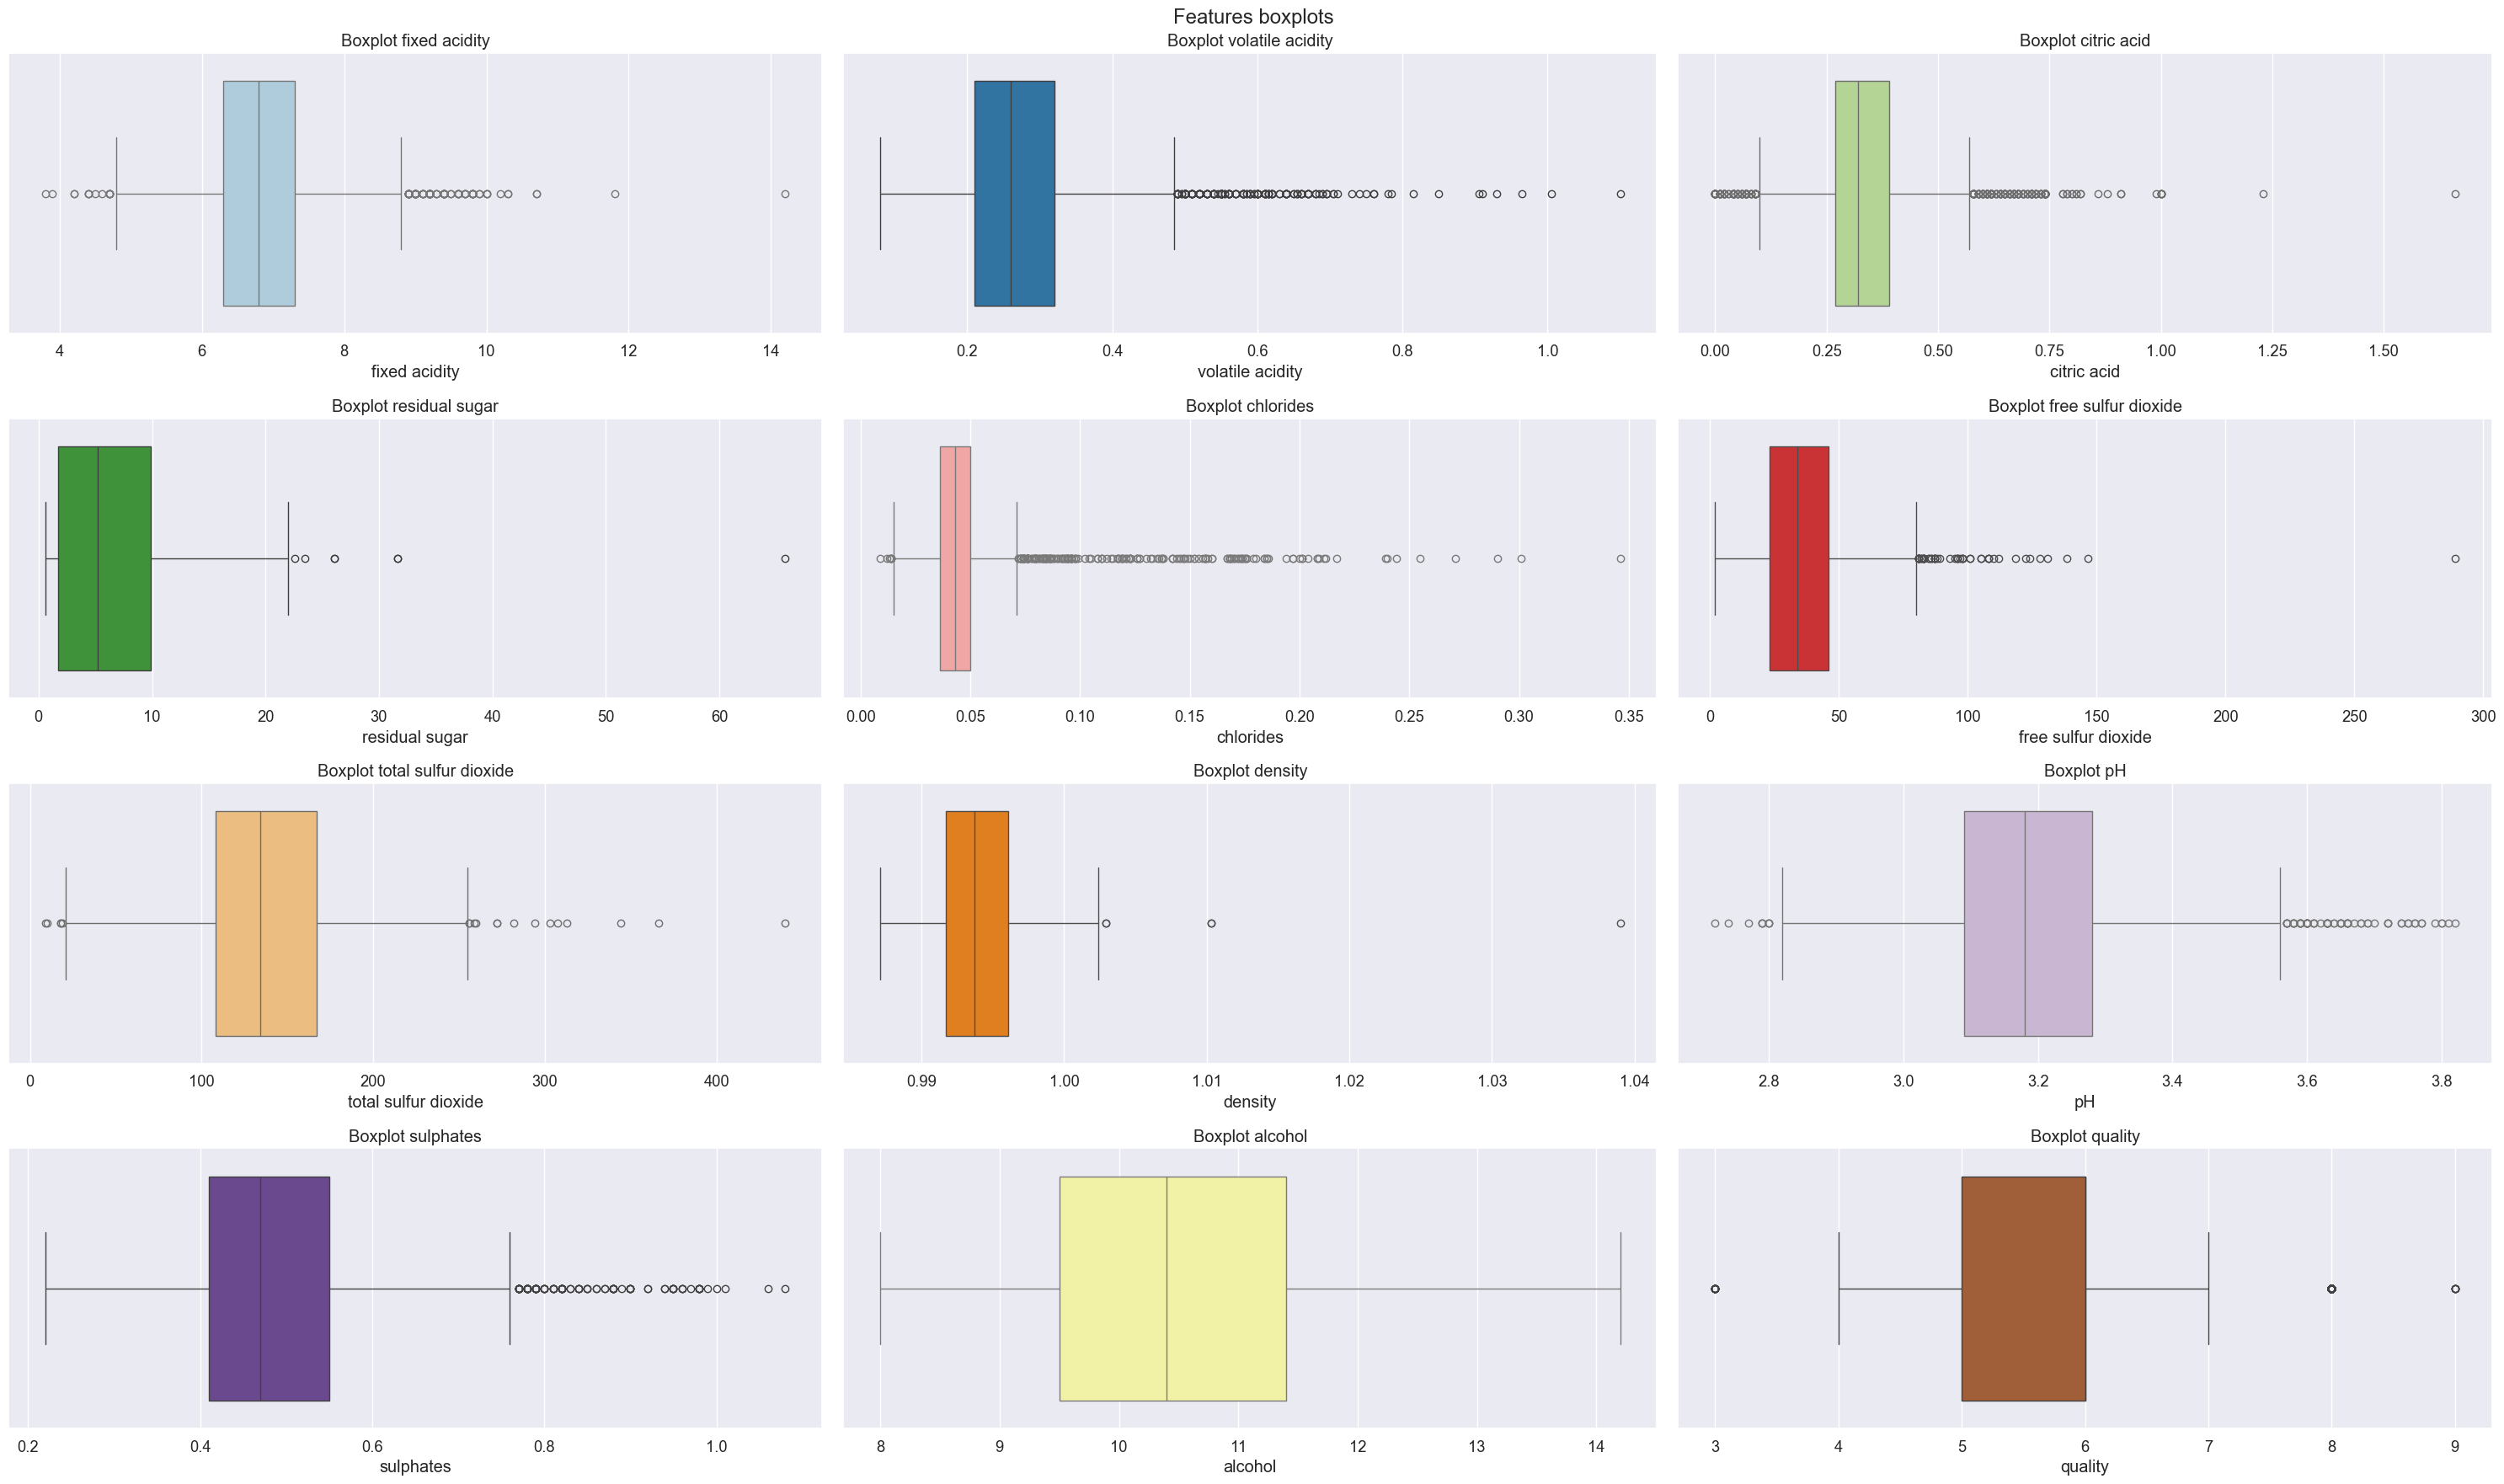

In [18]:
# Visualizando boxplot cada coluna
dataframe_boxplots(white_wine_df, color_dict)

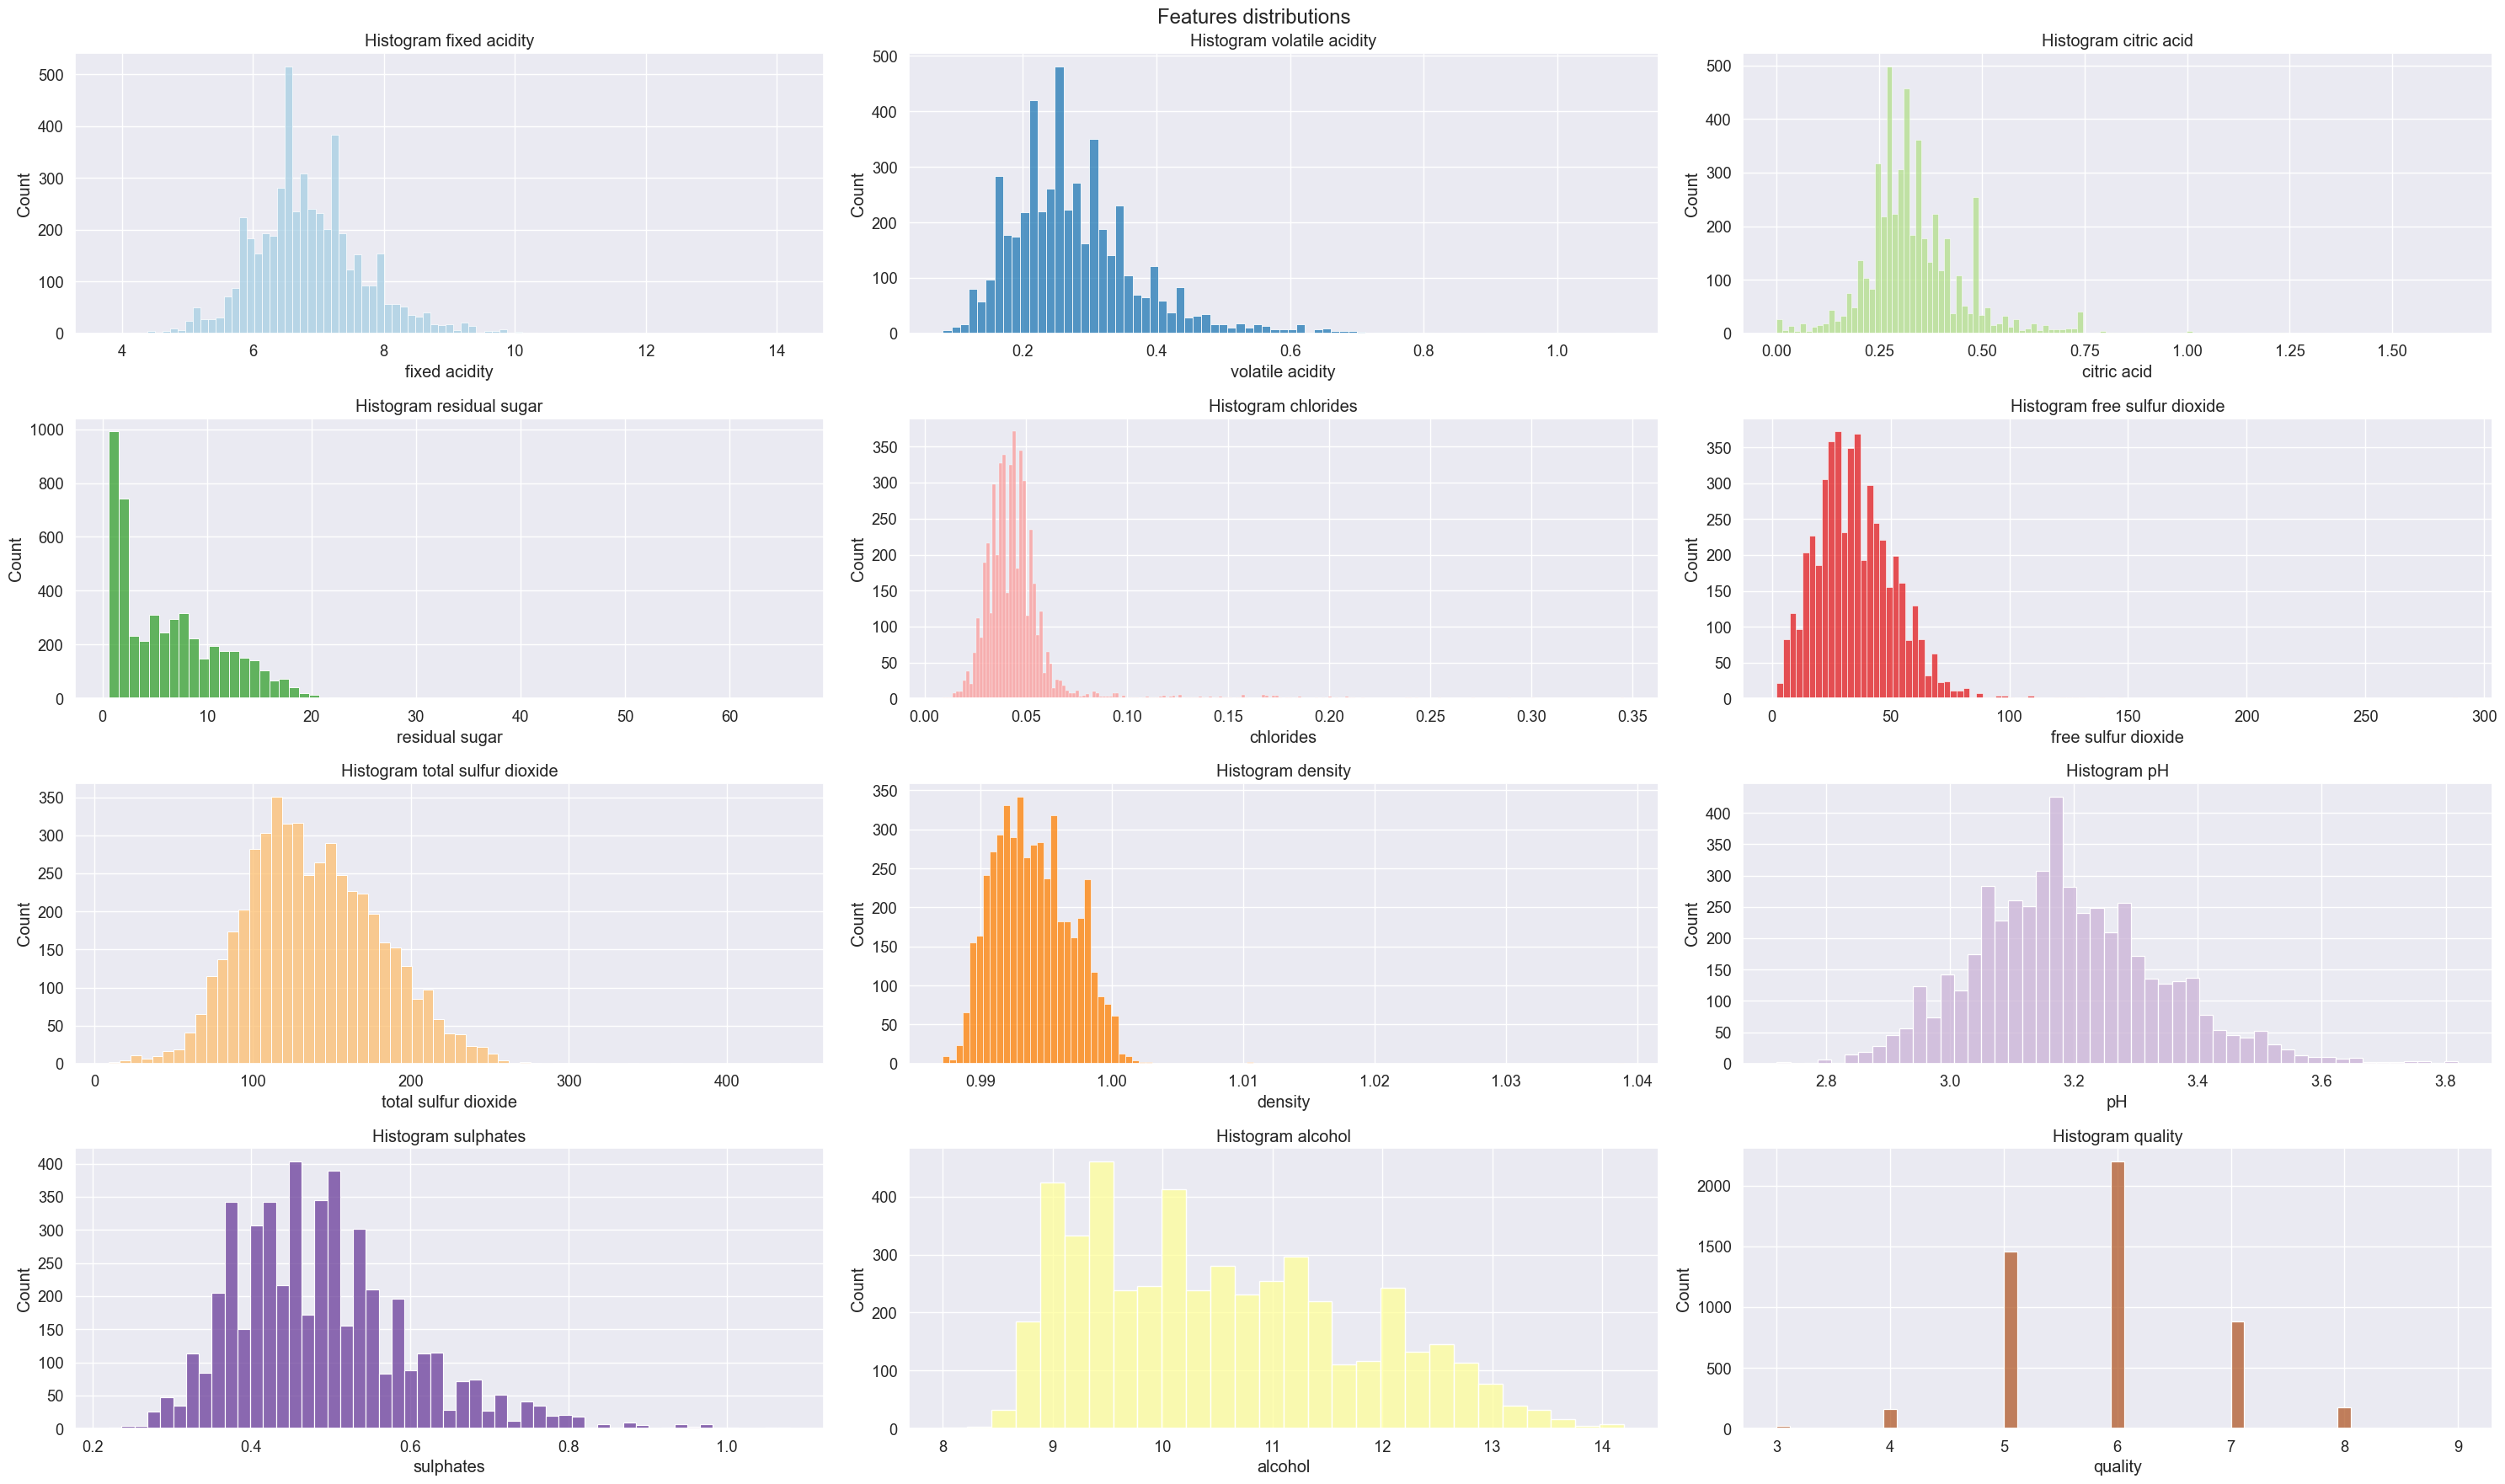

In [19]:
# Visualizando histogramas das colunas
dataframe_histograms(white_wine_df, color_dict)

### Lidando com outliers

Tratar outliers nesse workflow tem uma importância maior pelo uso de um modelo `XGBRegressor`, que possui sensibilidade a esses dados. Para tal, será feita uma análise de quantidade de dados a serem considerados outliers por cada feature.

Os dados que estão no quantil 99 foram descartados, com os outros sendo aproveitados. A quantidade final de dados que foi retirada foi de $733$, de um total de $4898$, aproximadamente $15\%$ dos dados totais.


In [20]:
# Obtendo os limites dos valores para todas as colunas
limit_columns = wine_df.drop('quality', axis=1).columns
limits = {
    col_name: upper_lower_limit(wine_df, col_name, 0.99) for col_name in limit_columns
}

for col_name, whisker in limits.items():
    print_whiskers(col_name, whisker)

--------------------------------------------------------------------------------
fixed acidity's whiskers:                          9.20 (upper) | 5.00 (lower) |
--------------------------------------------------------------------------------
volatile acidity's whiskers:                       0.63 (upper) | 0.12 (lower) |
--------------------------------------------------------------------------------
citric acid's whiskers:                            0.74 (upper) | 0.05 (lower) |
--------------------------------------------------------------------------------
residual sugar's whiskers:                        18.80 (upper) | 0.90 (lower) |
--------------------------------------------------------------------------------
chlorides's whiskers:                              0.16 (upper) | 0.02 (lower) |
--------------------------------------------------------------------------------
free sulfur dioxide's whiskers:                   81.00 (upper) | 6.00 (lower) |
----------------------------

In [21]:
# Definindo colunas a serem tratadas
outlier_columns = wine_df.columns.drop('quality')

In [22]:
# Criando cópia dos dados
wine_df = remove_outliers(wine_df, outlier_columns, limits)

In [23]:
# Comparando tamanhos dos datasets
len_white_wine_df = len(white_wine_df)
len_wine_df = len(wine_df)

print('Original dataset:         ', len_white_wine_df)
print('No outlier dataset:       ', len_wine_df)
print('-' * 35)
print('Total de dados retirados:  ', len_white_wine_df - len_wine_df)

Original dataset:          4898
No outlier dataset:        4165
-----------------------------------
Total de dados retirados:   733


### Correlação

Aqui foi calculada a correlação das features com a label `quality`. É possível ver que as colunas que tem maior correlação com a o score final são as features `density` e `alcohol`, com correlação negativa de ~`-0.3`, e correlação positiva de ~`0.44` respectivamente.

Outras correlações que são importantes são as das features `citric acid`, `sulphates`, e `free sulfur dioxide`, que são extremamente próximas de 0. Isso indica que essas medidas tem quase nenhuma proporcionalidade com a nota do vinho, ou seja, muito provavelmente terão muita pouca relevância em auxiliar a modelagem, pelo contrário, produzindo maior risco de introduzir "barulho".


In [24]:
# Calculando correlação entre variáveis
wine_corr_quality = white_wine_df.corr()['quality'].drop('quality')
wine_corr_quality = wine_corr_quality.sort_values()
wine_corr_quality.round(3)

density                -0.307
chlorides              -0.210
volatile acidity       -0.195
total sulfur dioxide   -0.175
fixed acidity          -0.114
residual sugar         -0.098
citric acid            -0.009
free sulfur dioxide     0.008
sulphates               0.054
pH                      0.099
alcohol                 0.436
Name: quality, dtype: float64

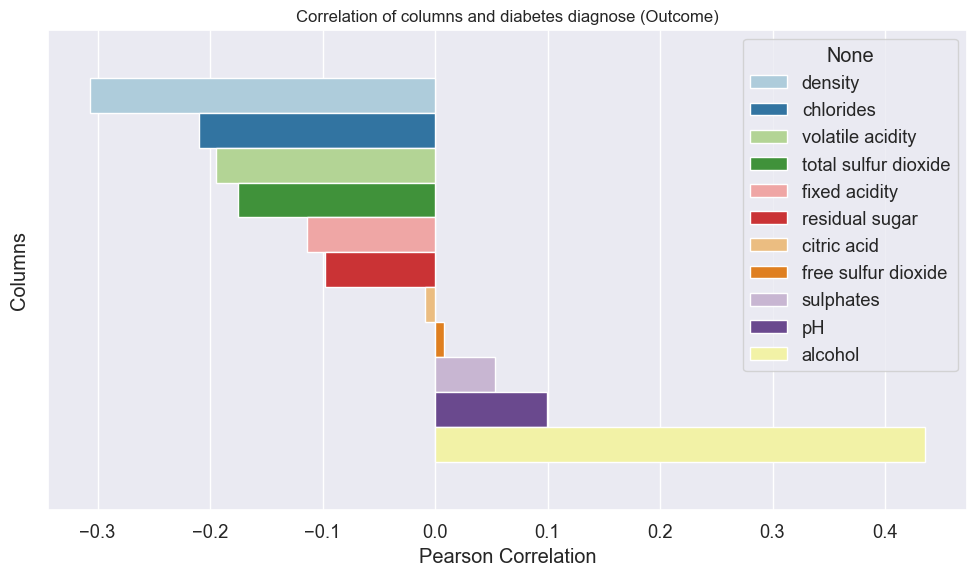

In [25]:
# Visualizando correlações
plot_correlation(wine_corr_quality, color_dict)

### Feature engineering

Nessa seção, foram criadas novas features por meio de:

- Interação entre features (multiplicação de valores de features)
- Razão entre features (dividindo uma feature pela outra)
- Log de features (para aumentar linearidade das distribuições).

Além disso, foram removidas 3 features, `citric acid`, `free sulfur dioxide`, e `chlorides`. As duas primeiras por terem correlações muito baixas com o alvo, enquanto a terceira foi retirada para diminuir a complexidade das features, vez que sua transformação logarítmica obteve melhores resultados.


In [26]:
# Features de interação
wine_df['alcohol_volatile'] = wine_df['alcohol'] * wine_df['volatile acidity']

# Features de razão
wine_df['sugar_alcohol_ratio'] = wine_df['residual sugar'] / (wine_df['alcohol'] + 1e-6)
wine_df['sulfur_ratio'] = wine_df['free sulfur dioxide'] / (
    wine_df['total sulfur dioxide'] + 1e-6
)

# Features logarítmicas
wine_df['log_sugar'] = np.log1p(wine_df['residual sugar'])
wine_df['log_chlorides'] = np.log1p(wine_df['chlorides'])
wine_df['log_sulphates'] = np.log1p(wine_df['sulphates'])

In [27]:
# Removendo colunas
wine_df.drop(columns=['citric acid', 'free sulfur dioxide', 'chlorides'], inplace=True)

In [28]:
# Recalculando correlação entre variáveis
wine_corr_quality = wine_df.corr()['quality'].drop('quality')
wine_corr_quality = wine_corr_quality.sort_values()
wine_corr_quality

density                -0.319939
log_chlorides          -0.258625
total sulfur dioxide   -0.198042
volatile acidity       -0.165732
sugar_alcohol_ratio    -0.148104
residual sugar         -0.110561
log_sugar              -0.091740
fixed acidity          -0.073021
alcohol_volatile        0.014861
log_sulphates           0.022641
sulphates               0.026361
pH                      0.085003
sulfur_ratio            0.192901
alcohol                 0.438811
Name: quality, dtype: float64

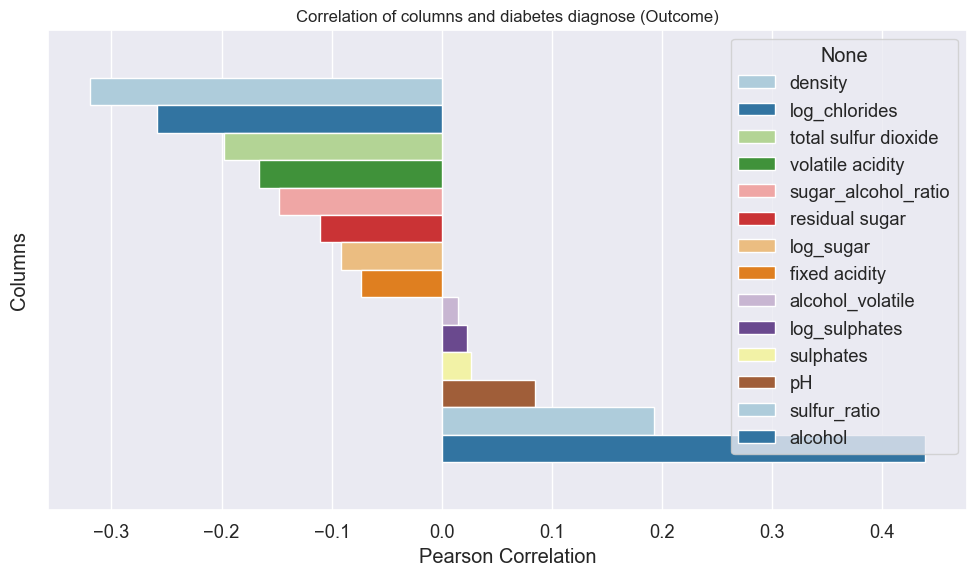

In [29]:
# Visualizando novas correlações
plot_correlation(wine_corr_quality, color_dict)

### Separando dados

Separando dados por _hold-out_.


In [30]:
# Separando dados em treino e teste
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Modelagem

Para as modelagens, foram usados dois estimadores:

- `XGBRegressor`: algoritmo de otimização de gradiente que cria árvores sequencialmente, com dada árvore tentando corrigir os erros da versão prévia. Esse treinamento aditivo proporciona a esse tipo de estimador a aprender padrões mais complexos.

- `RandomForestRegressor`: algoritmo que usa amostras bootstrap, o que significa que cada árvore vê um subconjunto dos dados. Isso significa que cada uma é treinada de forma independente, sem necessidade de processamento sequencial. Além disso, esse estimador faz a média das previsões, se tornando mais robusto a dados ruidosos ou esparsos.

Ambos foram compostos por pipelines onde os dados foram normalizados antes do treinamento dos modelos.

Foram feitas duas formas de modelagem, uma modelagem simples e outra fazendo ajustes nos hiperparâmetros dos estimadores, aplicando validação cruzada com `RandomSearchCV`.


### Modelagem simples

Modelagem sem ajustes nos hiperparâmetros do modelo e sem validação cruzada.


In [ ]:
# Instanciando pipeline RandomForestRegressor
rf_model = estimator_pipeline(RandomForestRegressor)
rf_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))])

In [ ]:
# Instanciando pipeline XGBRegressor
xgb_model = estimator_pipeline(XGBRegressor)
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

### Modelagem com RandomSearchCV

Foram escolhidos grids de parâmetros para optimização de cada um dos modelos com base em seus hiperparâmetros customizáveis, e os valores que podem assumir.


In [33]:
# Criando grids de parâmetros
rf_param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [10, 15, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2'],
    'model__bootstrap': [True, False],
}

xgb_param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [6, 8, 10],
    'model__min_child_weight': [1, 5, 10],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.3],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 5, 10],
}

In [ ]:
# Instanciando pipeline RandomForestRegressor com RandomSearchCV
rf = estimator_pipeline(RandomForestRegressor)
rf_rs_model = RandomizedSearchCV(
    rf, rf_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1
)
rf_rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 15, 20, None],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [100, 300, 500]},
                   scoring='r2', verbose=1)

In [ ]:
# Instanciando pipeline XGBRegressor com RandomSearchCV
xgb = estimator_pipeline(XGBRegressor)
xgb_rs_model = RandomizedSearchCV(
    xgb, xgb_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1
)
xgb_rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           feature_weights=None,
                                                           gamma=None,
                                                           grow_po...
                   n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.7, 0.8,
                                                                    1.0],
                                        'model__gamma': [0, 0.1, 0.3],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [6, 8, 10],
                                        'model__min_child_weight': [1, 5, 10],
                                        'model__n_estimators': [100, 300, 500],
                                        'model__reg_alpha': [0, 0.1, 1],
                                        'model__reg_lambda': [1, 5, 10],
                                        'model__subsample': [0.7, 0.8, 1.0]},
                   scoring='r2', verbose=1)

## Avaliando performance

Para avaliação dos modelos, foram usadas duas métricas as seguintes métricas:

### Coeficiente de determinação $R^2$

A métrica $R^2$ (ou coeficiente de determinação), mede a proporção da variância dos dados que é explicada pelo modelo. Definida no intervalo $[0,1]$, onde valores mais próximos de 1 denotam um modelo que "explica" a variação dos dados, ou seja, suas previsões não estão correlacionadas com valores reais.

Enquanto valores de 0 indicam que o modelo não explica nenhuma variação dos dados, ou seja, suas previsões não estão correlacionadas com os valores reais.

- $R^2$ modelo simples:

  - `RandomForestRegressor`: ~$0.528$
  - `XGBRegressor`: ~$0.473$

- $R^2$ modelo `RandomSearchCV`:
  - `RandomForestRegressor`: ~$0.551$
  - `XGBRegressor`: ~$0.533$

Nenhuma das modelagens obteve grandes valores de coeficiente de determinação, ou seja, os modelos conseguem "explicar" $+/-50\%$ da variância dos dados. Apesar disso, é possível ver que ambos os modelos beneficiaram do ajuste de hiperparâmetros, em especial o modelo `XGBRegressor`, que saltou de um valor de $R^2$ de ~$0.473$, para ~$0.533$.

### Raiz do erro quadrático médio $RMSE$

A métrica $RMSE$ (_Root Mean Squared Error_) mede o erro médio das previsões do modelo em relação aos valores reais, sendo interpretada na mesma unidade da variável alvo. Aqui, menores valores indicam melhor desempenho.

- $RMSE$ Modelos Simples:

  - `RandomForestRegressor`: ~$0.598$
  - `XGBRegressor`: ~$0.631$

- $RMSE$ Modelos `RandomSearchCV`:
  - `RandomForestRegressor`: ~$0.583$
  - `XGBRegressor`: ~$0.595$

Assim como para o $R^2$, nenhum dos modelos teve grandes resultados, nem melhora de performance para a métrica $RMSE$. Todos eles caíram na faixa de ~$0.6$ de distância do valor real, o que representa um desvio relativamente pequeno, mostrando que o modelo é impreciso, mas pode ser considerável moderadamente confiável.


### Prevendo valores


In [36]:
# Prevendo valores

# Modelos simples
xgb_y_pred = xgb_model.predict(X_test)
rf_y_pred = rf_model.predict(X_test)

# Modelos RandomSearch
xgb_rs_y_pred = xgb_rs_model.predict(X_test)
rf_rs_y_pred = rf_rs_model.predict(X_test)

In [37]:
# Verificando RMSE dos modelos

# Modelos Simples
rmse_rf = root_mean_squared_error(y_pred=rf_y_pred, y_true=y_test)
rmse_xgb = root_mean_squared_error(y_pred=xgb_y_pred, y_true=y_test)

# Modelos RandomSearch
rmse_rf_rs = root_mean_squared_error(y_pred=rf_rs_y_pred, y_true=y_test)
rmse_xgb_rs = root_mean_squared_error(y_pred=xgb_rs_y_pred, y_true=y_test)

### Resultados


In [ ]:
# Modelos simples
print()
print(
    '-' * 45,
    f'R^2 modelo simples:\nRandomForestRegressor: {round(rf_model.score(X_test, y_test), 3)}\nXGBRegressor: {round(xgb_model.score(X_test, y_test), 3)}\n',
    sep='\n',
)

# RandomSearch
print(
    '-' * 45,
    f'R^2 modelo RandomSearchCV:\nRandomForestRegressor: {round(rf_rs_model.score(X_test, y_test), 3)}\nXGBRegressor: {round(xgb_rs_model.score(X_test, y_test), 3)}\n',
    sep='\n',
)


---------------------------------------------
R^2 modelo simples:
RandomForestRegressor: 0.528
XGBRegressor: 0.473

---------------------------------------------
R^2 modelo RandomSearchCV:
RandomForestRegressor: 0.551
XGBRegressor: 0.533



In [ ]:
# RMSE para modelos simples
print(
    '-' * 45,
    f'RMSE Modelos Simples:\nRandomForest: {round(rmse_rf,3)}\nXGBRegressor: {round(rmse_xgb,3)}\n',
    sep='\n',
)

# RMSE para modelos RandomSearch
print(
    '-' * 45,
    f'RMSE Modelos RandomSearchCV:\nRandomForest: {round(rmse_rf_rs,3)}\nXGBRegressor: {round(rmse_xgb_rs,3)}\n',
    sep='\n',
)

---------------------------------------------
RMSE Modelos Simples:
RandomForest: 0.598
XGBRegressor: 0.631

---------------------------------------------
RMSE Modelos RandomSearchCV:
RandomForest: 0.583
XGBRegressor: 0.595



### Feature Importance

Foi calculada a importância das features para cada modelo, com a feature `alcohol` sendo de longe a mais relevante para os dois modelos.


------------------------------------
                 Feature  Importance
7                alcohol    0.268797
1       volatile acidity    0.142534
10          sulfur_ratio    0.064156
2         residual sugar    0.062379
12         log_chlorides    0.061062
3   total sulfur dioxide    0.059834
8       alcohol_volatile    0.059359
4                density    0.059218
0          fixed acidity    0.057468
5                     pH    0.056099
9    sugar_alcohol_ratio    0.055780
6              sulphates    0.053314
11             log_sugar    0.000000
13         log_sulphates    0.000000
------------------------------------


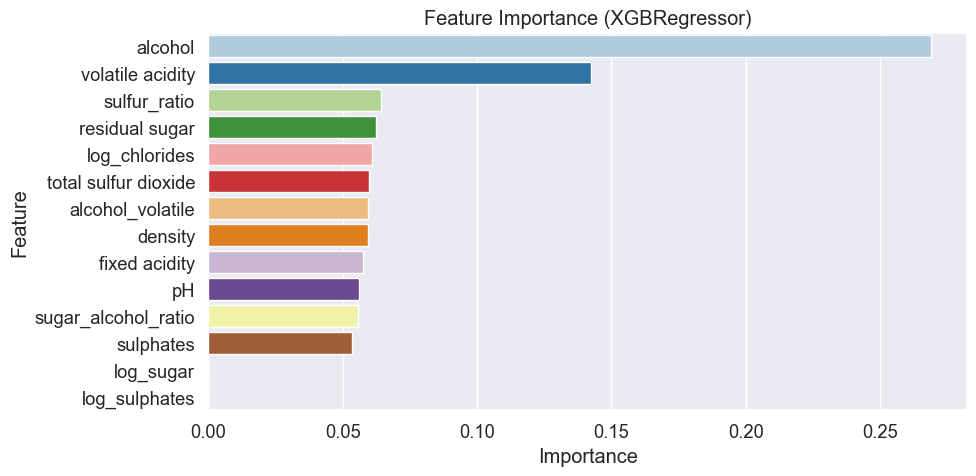

In [ ]:
# Obtendo feature importance para XGBRegressor

# Obtendo melhor modelo
best_model = xgb_rs_model.best_estimator_.named_steps['model']

# Dataframe de importância de features
importance_df = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_,
    }
).sort_values(by='Importance', ascending=False)

print('-' * 36, importance_df, '-' * 36, sep='\n')

# Plot da importância das features
plt.figure(figsize=(10, 5))
sns.barplot(
    data=importance_df, x='Importance', y='Feature', hue='Feature', palette='Paired'
)
plt.title(f'Feature Importance ({type(best_model).__name__})')
plt.tight_layout()
plt.show()

------------------------------------
                 Feature  Importance
7                alcohol    0.155773
4                density    0.104185
10          sulfur_ratio    0.083637
8       alcohol_volatile    0.078538
12         log_chlorides    0.077833
1       volatile acidity    0.074538
3   total sulfur dioxide    0.072611
9    sugar_alcohol_ratio    0.060961
5                     pH    0.057993
0          fixed acidity    0.050511
2         residual sugar    0.049690
11             log_sugar    0.048980
6              sulphates    0.042382
13         log_sulphates    0.042370
------------------------------------


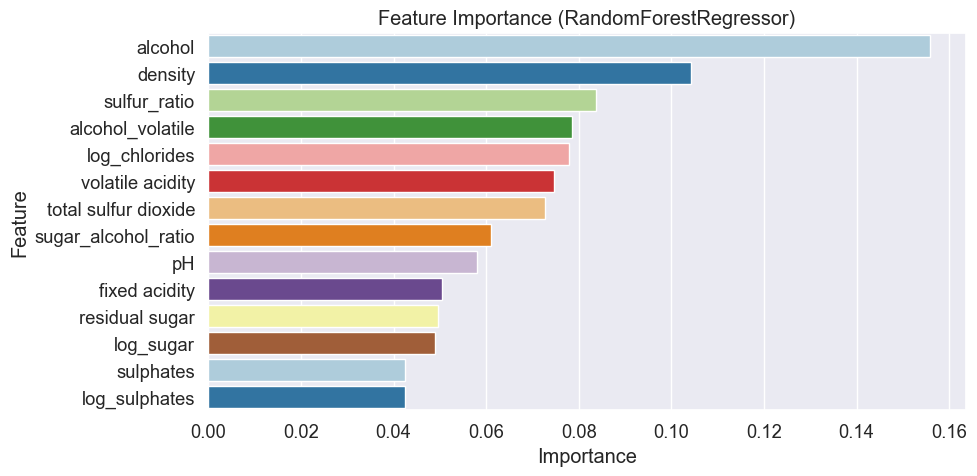

In [49]:
best_model = rf_rs_model.best_estimator_.named_steps['model']

importance_df = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_,
    }
).sort_values(by='Importance', ascending=False)

print('-' * 36, importance_df, '-' * 36, sep='\n')

plt.figure(figsize=(10, 5))
sns.barplot(
    data=importance_df, x='Importance', y='Feature', hue='Feature', palette='Paired'
)
plt.title(f'Feature Importance ({type(best_model).__name__})')
plt.tight_layout()
plt.show()

## Salvando modelos


In [1]:
# Criando pasta de modelos
!mkdir ../modelos
!mkdir ../modelos/regressao

mkdir: ../modelos: File exists


In [ ]:
# Salvando RandomForestRegressor com RandomSearchCV
pickle.dump(rf_rs_model, open('../modelos/regresao/rf_rs_model.pkl', 'wb'))

# Salvando XGBRegressor com RandomSearchCV
pickle.dump(xgb_rs_model, open('../modelos/regressao/xgb_rs_model.pkl', 'wb'))

## Conclusão

A modelagem dos dados foi feita com dois modelos, primeiramente uma simples e em seguida uma com ajuste de hiperparâmetros. Para ambas, os resultados obtidos para $R^2$ foi de aproximadamente $0.5$, enquanto o $RMSE$ foi de aproximadamente $0.6$.

Apesar de serem resultados pouco satisfatórios, podem ser justificados por alguns fatores. Primeiramente, a quantidade de dados que foram usados para a modelagem, após a retirada de outliers, foi de aproximadamente $4000$ dados, o que é um dataset relativamente pequeno. Essa baixa quantidade de dados faz com que modelos como o `XGBRegressor` não funcionem de forma ideal, vez que são sujeitos a um maior overfitting devido à baixa quantidade de dados.

O segundo fator, e talvez mais importante é que, dar nota a vinhos é algo extremamente subjetivo, com cada uma das features sendo interpretadas de forma diferente a depender do paladar individual do crítico.
